# ECE176: Pneumonia Detection, CNN

## Introduction

**In this report, we aim to address the following questions:**

1. How accurately can we distinguish healthy and pneumonia patients with our CNN? 

2. Can we distinguish between viral and bacterial pneumonia? 
       
3. Can we use pre-trained CNNs or UNET models to create a more accurate model? 

## Dataset

[Collection of Chest X Ray of Healthy vs Pneumonia affected patients](https://www.kaggle.com/datasets/praveengovi/coronahack-chest-xraydataset)

## Import Packages and Prepare GPU

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision

import numpy as np
import os
import pandas as pd
import shutil
import matplotlib.pyplot as plt

c:\Users\16262\miniconda3\envs\cse151b\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


## Load Dataset With Augmentations

We first need to split the images based on labeled classes to use the Dataloader.

**Note: This only needs to be run one time**

In [3]:
# first read in the metadata file
data = pd.read_csv("Chest_xray_Corona_Metadata.csv")
data.head(10)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
5,5,IM-0117-0001.jpeg,Normal,TRAIN,NaN,NaN
6,6,IM-0115-0001.jpeg,Normal,TRAIN,NaN,NaN
7,7,IM-0189-0001.jpeg,Normal,TRAIN,NaN,NaN
8,8,IM-0187-0001.jpeg,Normal,TRAIN,NaN,NaN
9,9,IM-0185-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
print(set(data['Label']))

{'Normal', 'Pnemonia'}


In [5]:
# subdirectories for each class
#os.mkdir("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/Pnemonia")
#os.mkdir("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/Normal")
#os.mkdir("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/Pnemonia")
#os.mkdir("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/Normal")

In [6]:
path_train = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train"
path_test = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test"

train_num = len(os.listdir(path_train))
print("Train data: " + str(train_num))
test_num = len(os.listdir(path_test))
print("Test data: " + str(test_num))


Train data: 5311
Test data: 626


In [7]:
# ONLY NEED TO RUN ONCE

normal_train = 0
pnemonia_train = 0
normal_test = 0
pnemonia_test = 0

# "X_ray_image_name" = name of file
# "Label" = pneumonia or normal
# "Dataset_type" = train or test

for i in range(data.shape[0]):
    if data["Dataset_type"][i] == "TRAIN":
        if data["Label"][i] == "Normal":
            shutil.copy(path_train + "/" + data["X_ray_image_name"][i], path_train + "/Normal/" + data["X_ray_image_name"][i])
            normal_train = normal_train + 1
        else:
            shutil.copy(path_train + "/" + data["X_ray_image_name"][i], path_train + "/Pnemonia/" + data["X_ray_image_name"][i])
            pnemonia_train = pnemonia_train + 1
    elif data["Dataset_type"][i] == "TEST":
        if data["Label"][i] == "Normal":
            shutil.copy(path_test + "/" + data["X_ray_image_name"][i], path_test + "/Normal/" + data["X_ray_image_name"][i])
            normal_test = normal_test + 1
        else:
            shutil.copy(path_test + "/" + data["X_ray_image_name"][i], path_test + "/Pnemonia/" + data["X_ray_image_name"][i])
            pnemonia_test = pnemonia_test + 1

print(
    "X-ray of Normal patients (TRAIN DATASET): " + str(normal_train) + "\n",
    "X-ray of Infected patients (TRAIN DATASET): " + str(pnemonia_train) + "\n",
    "X-ray of Normal patients (TEST DATASET): " + str(normal_test) + "\n",
    "X-ray of Infected patients (TEST DATASET): " + str(pnemonia_test) + "\n"
)

X-ray of Normal patients (TRAIN DATASET): 1342
 X-ray of Infected patients (TRAIN DATASET): 3944
 X-ray of Normal patients (TEST DATASET): 234
 X-ray of Infected patients (TEST DATASET): 390



In [8]:
# redefine number of train test 
train_num = normal_train + pnemonia_train
print("Train data: " + str(train_num))
test_num = normal_test + pnemonia_test
print("Test data: " + str(test_num))

Train data: 5286
Test data: 624


In [9]:
train_data_path = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/"
test_data_path = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/"
batch_size = 64

# data augmentation 
transform = T.Compose([
    T.Resize(256),
    T.RandomHorizontalFlip(), # horizontal flips
    T.CenterCrop(256), # crops
    T.ToTensor(),
    T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) # hard coded mean and std rgb values from assignment 5
    ])

train_data = dset.ImageFolder(root=train_data_path, transform=transform)
train_data_loader = DataLoader(train_data, batch_size=batch_size, num_workers=2, sampler=sampler.SubsetRandomSampler(range(train_num)))
test_data = dset.ImageFolder(root=test_data_path, transform=transform)
test_data_loader  = DataLoader(test_data, batch_size=batch_size, num_workers=2, sampler=sampler.SubsetRandomSampler(range(test_num))) 


# Visualize Data

### Counting the number of images in each class

In this dataset, we categorize the images into two classes: 'Normal' and 'Pneumonia.' In the plot below, 'Normal' instances are colored red, while 'Pneumonia' cases are green.

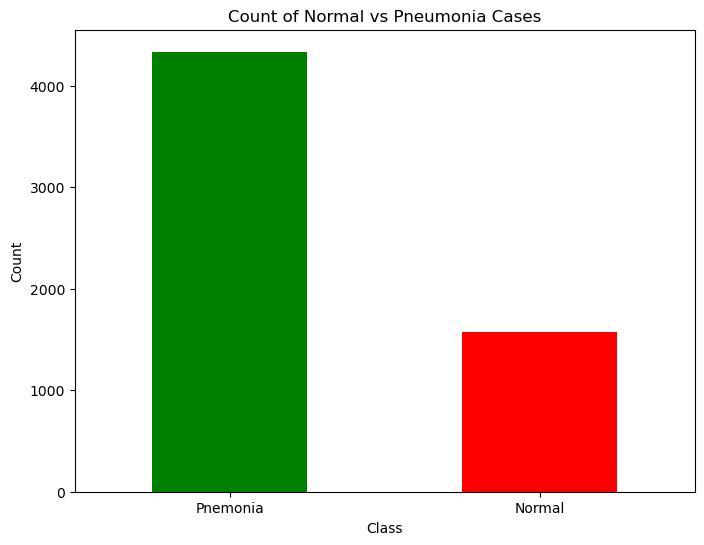

Label
Pnemonia    4334
Normal      1576
Name: count, dtype: int64


In [10]:
# Count number of images in each class
class_counts = data['Label'].value_counts()

# Specify colors for each class
colors = ['red' if label == 'Normal' else 'green' for label in class_counts.index]

# Plotting
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=colors)
plt.title('Count of Normal vs Pneumonia Cases')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep the class names horizontal for readability
plt.show()
print(class_counts)

It is important for us to make sure that our training and testing folds have similar ratios of normal and pneumonia images.

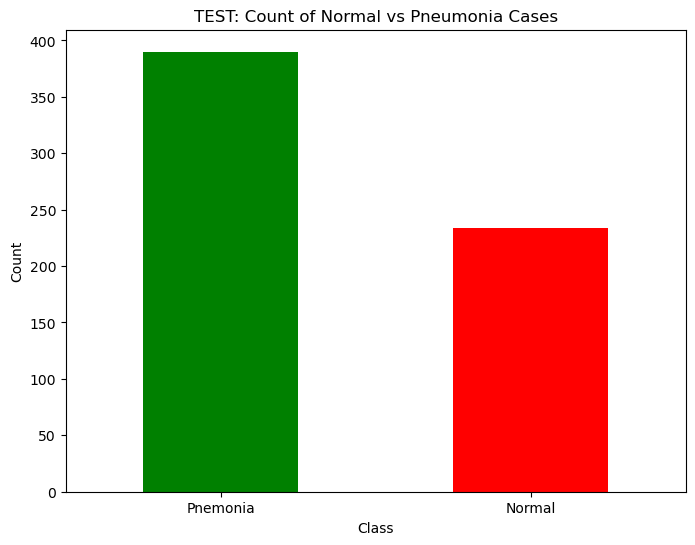

Label
Pnemonia    390
Normal      234
Name: count, dtype: int64


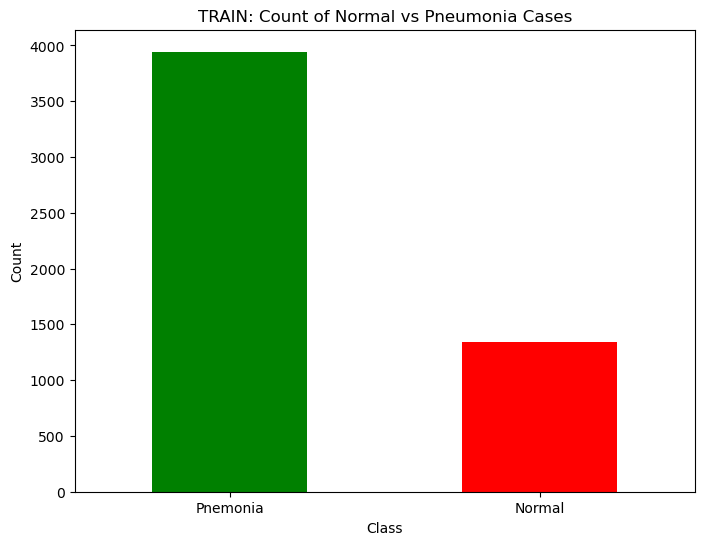

Label
Pnemonia    3944
Normal      1342
Name: count, dtype: int64


In [11]:
train_test_grouped = data.groupby('Dataset_type')

for name, group in train_test_grouped:
    # Count number of images in each class
    class_counts = group['Label'].value_counts()

    # Specify colors for each class
    colors = ['red' if label == 'Normal' else 'green' for label in class_counts.index]

    # Plotting
    plt.figure(figsize=(8, 6))
    class_counts.plot(kind='bar', color=colors)
    plt.title( name + ': Count of Normal vs Pneumonia Cases')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)  # Keep the class names horizontal for readability
    plt.show()
    print(class_counts)

> This shows that our model will be training and testing on similar ratios of case and control images.

### Visualizing the chest X-rays

In [12]:
def imshow(inp, title=None): # visualize tensors as images
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 5)) 
    plt.imshow(inp, cmap='gist_heat')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Visualizing the input images from the training data:

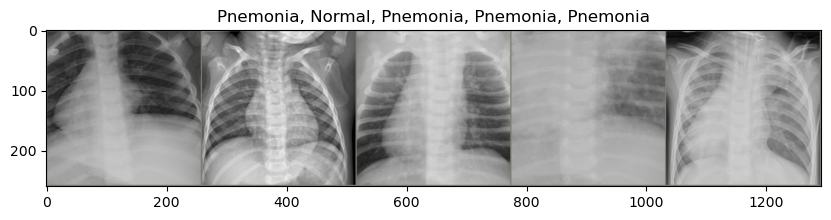

In [13]:
inputs, classes = next(iter(train_data_loader))

indices = torch.randperm(len(inputs))[:5] # randomly grab 5 images
selected_inputs = inputs[indices]
selected_classes = classes[indices]

# Make a grid from the selected batch
out = torchvision.utils.make_grid(selected_inputs)

# Create titles for the selected images
selected_titles = ', '.join([train_data.classes[x] for x in selected_classes])

# Call imshow with the selected images and titles
imshow(out, title=selected_titles)

Visualizing the input images from the testing data:

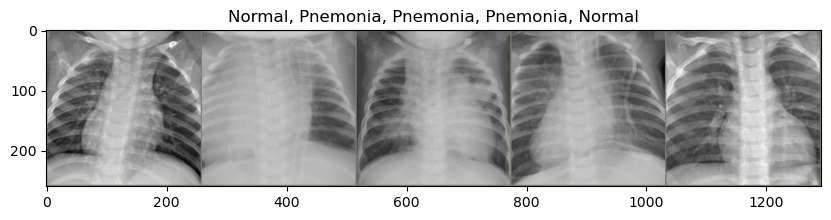

In [14]:
inputs, classes = next(iter(test_data_loader))

indices = torch.randperm(len(inputs))[:5]
selected_inputs = inputs[indices]
selected_classes = classes[indices]

out = torchvision.utils.make_grid(selected_inputs)

selected_titles = ', '.join([test_data.classes[x] for x in selected_classes])

imshow(out, title=selected_titles,)

In [15]:
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Data Augmentation and Normalization
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),  # Resize images to fit models like ResNet
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(path_train, transform=train_transforms)
test_dataset = datasets.ImageFolder(path_test, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

> In this section, we visualized 5 random images from the training and testing set. We can see that the inflammation of the lungs is visible in these chest X-rays for patients with pneumonia. 

# Define Training and Testing functions

In [16]:
def flatten(x):
    N = x.shape[0] 
    return x.view(N, -1)

In [17]:
import torch.nn.functional as F

# Define a function for calculating accuracy
def check_accuracy(loader, model):
    """
    Checks the accuracy of the model on a dataset provided by 'loader'
    
    Inputs:
    - loader: Data loader for the dataset to check against
    - model: A PyTorch Module giving the model to check
    
    Returns:
    - accuracy: Scalar giving the fraction of instances that were correctly classified by the model
    """
    num_correct = 0
    num_samples = 0
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)  # Move to the correct device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    
    accuracy = float(num_correct) / num_samples
    return accuracy



In [18]:
def train_test_model(model, train_loader, test_loader, optimizer, scheduler, criterion, num_epochs=10):
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Scheduler step (if using learning rate decay)
        scheduler.step()

        # Evaluation loop
        model.eval()  # Set model to evaluation mode
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)

        # Print epoch results
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / total_train:.4f}, '
              f'Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')
    
    return train_accuracies, test_accuracies

# Simple CNN

### Defining the simple CNN architecture

In [19]:
# Define the CNN architecture code form cse251b project
class PneumoniaSimpleCNN(nn.Module):
    def __init__(self, num_classes=2):  # 2 classes: Normal, Pneumonia
        super(PneumoniaSimpleCNN, self).__init__()
        # Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.bnd1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bnd2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bnd3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bnd4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.bnd5 = nn.BatchNorm2d(512)
        self.relu = nn.ReLU(inplace=True)
        # Adaptive Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Reduce to 1x1 feature map
        # Final classifier
        self.classifier = nn.Linear(512, num_classes)
        
    def forward(self, x):
        
        x = self.relu(self.bnd1(self.conv1(x)))
        x = self.relu(self.bnd2(self.conv2(x)))
        x = self.relu(self.bnd3(self.conv3(x)))
        x = self.relu(self.bnd4(self.conv4(x)))
        x = self.relu(self.bnd5(self.conv5(x)))
        # Adaptive pooling and classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten the layer to feed into the classifier
        x = self.classifier(x)
        return x

### Train and Test the Simple CNN model

In [20]:
num_classes = 2  # Normal, Pneumonia
learning_rate = 1e-4
num_epochs = 10
from torch.optim import lr_scheduler

# Define the model 
model = PneumoniaSimpleCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.8)
# Train the model
train_accuracies, test_accuracies = train_test_model(model, train_loader, test_loader, optimizer, scheduler, criterion, num_epochs=10)


Epoch 1/10, Loss: 0.2576, Train Accuracy: 89.92%, Test Accuracy: 84.13%
Epoch 2/10, Loss: 0.1729, Train Accuracy: 93.32%, Test Accuracy: 84.62%
Epoch 3/10, Loss: 0.1464, Train Accuracy: 94.38%, Test Accuracy: 69.71%
Epoch 4/10, Loss: 0.1339, Train Accuracy: 95.21%, Test Accuracy: 66.83%
Epoch 5/10, Loss: 0.1292, Train Accuracy: 95.14%, Test Accuracy: 77.24%
Epoch 6/10, Loss: 0.1197, Train Accuracy: 95.37%, Test Accuracy: 85.58%
Epoch 7/10, Loss: 0.1210, Train Accuracy: 95.35%, Test Accuracy: 70.51%
Epoch 8/10, Loss: 0.1117, Train Accuracy: 95.61%, Test Accuracy: 77.08%
Epoch 9/10, Loss: 0.1033, Train Accuracy: 96.16%, Test Accuracy: 72.44%
Epoch 10/10, Loss: 0.1021, Train Accuracy: 96.12%, Test Accuracy: 86.22%


### Visualize the image, true labels, and predicted labels

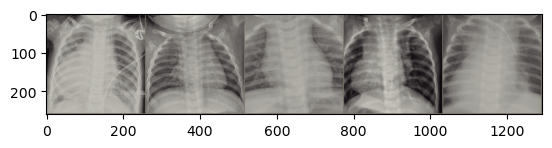

True labels:  Pnemonia Normal Pnemonia Pnemonia Pnemonia
Predicted:  Normal Normal Normal Normal Normal


In [ ]:
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))  # convert from Tensor image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values to [0, 1] range
    plt.imshow(img)
    plt.show()

# Assuming test_data_loader has batch_size at least 5 or adjust as necessary
# Get a batch of test images and labels
dataiter = iter(test_data_loader)
images, labels = next(dataiter)

# Select random 5 indices
idx = np.random.choice(images.size(0), 5, replace=False)

# Select random images and labels
random_images = images[idx]
random_labels = labels[idx]

# Move tensors to the configured device
random_images, random_labels = random_images.to(device), random_labels.to(device)

# Get predictions
model.eval()  # Make sure model is in eval mode
with torch.no_grad():
    outputs = model(random_images)
    _, predicted = torch.max(outputs, 1)

# Show images
imshow(torchvision.utils.make_grid(random_images.cpu()))
# Print true and predicted labels
print('True labels: ', ' '.join(f'{test_data.classes[random_labels[j].item()]}' for j in range(len(random_labels))))
print('Predicted: ', ' '.join(f'{test_data.classes[predicted[j].item()]}' for j in range(len(predicted))))

### Visualize accuracy over epochs 

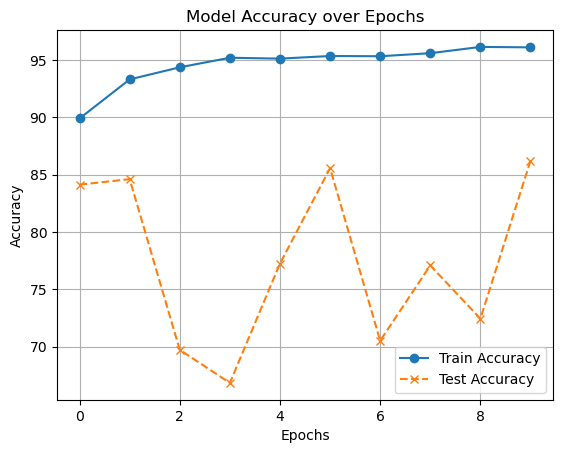

In [22]:
# accuracies is a list of accuracies of the model for each epoch 
epochs = range(0,num_epochs) # the last epoch here represents the final prediction 
# train_accuracies, test_accuracies = train_test_model(model, optimizer, num_epochs)

# plot accuracies over epochs
plt.plot(epochs, train_accuracies, marker='o', linestyle='-', label='Train Accuracy')
plt.plot(epochs, test_accuracies, marker='x', linestyle='--', label='Test Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

> Note: This accuracy of 78% is not that impressive when we consider the ratio of the number of pneumonia and normal images in the testing set. This is because simply predicting Pnemonia for every image will result in a 62.5% accuracy. 

# Resnet CNN

### Can Resnet CNN be applied to classify chest X-rays?

### Define the Resnet Architecture

In [23]:
class ResNetBlocks(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, batchnorm=True):
        super(ResNetBlocks, self).__init__()
        
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True) #relu
        self.out_channels = out_channels
        
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, (3,3), stride=stride, padding = 1),
            nn.ReLU(inplace=True)
        )
        if batchnorm:
            self.conv_1 = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, (3,3), stride=stride, padding = 1), 
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
                )
        
        self.conv_2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, (3,3), stride=1, padding = 1)
        )
        if batchnorm:
            self.conv_2 = nn.Sequential(
                nn.Conv2d(out_channels, out_channels, (3,3), stride=1, padding = 1), 
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        resid=x
        out = self.conv_1(x)
        out = self.conv_2(out)
        if self.downsample:
            resid=self.downsample(x)
        out = out + resid
        out = self.relu(out)
        return out
        
    
class ResNet(nn.Module):
    
    def __init__(self, block, num_blocks, batchnorm=True):
        super(ResNet, self).__init__()
        
        self.inchannel=64 # current channel size, used later for skips 
        
        self.convlayer_1 = nn.Sequential(
            nn.Conv2d(3, 64, (7,7), stride=2, padding=3),
            nn.ReLU(inplace=True)
        )
        
        if batchnorm:
            self.convlayer_1 = nn.Sequential(
                nn.Conv2d(3, 64, (7,7), stride=2, padding=3),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            )
        
        self.maxpool = nn.MaxPool2d((3,3), stride=2, padding = 1)
        
        self.block1 = self.make_layer(block, 64, num_blocks[0], stride = 1)
        self.block2 = self.make_layer(block, 128, num_blocks[1], stride = 1)
        self.block3 = self.make_layer(block, 256, num_blocks[2], stride = 1)
        self.block4 = self.make_layer(block, 512, num_blocks[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        #self.dropout = nn.Dropout2d(p=0.3)
        self.fc = nn.Linear( 512, num_class) 
        #nn.init.kaiming_normal_(self.fc.weight)
    
    def make_layer(self, block, channel, numblocks, stride=1, batchnorm=True):
        downsample = None
        if self.inchannel != channel:
            downsample = nn.Sequential(
                nn.Conv2d(self.inchannel, channel, (1,1), stride=stride) # add skip arrow
            )
            if batchnorm:
                downsample = nn.Sequential(
                    nn.Conv2d(self.inchannel, channel, (1,1), stride=stride), # add skip arrow
                    nn.BatchNorm2d(channel)
                )
            
        layers = []
        layers.append(block(self.inchannel, channel, stride, downsample))
        self.inchannel = channel #update current channel
        
        # add number of blocks here 
        for j in range(1,numblocks): # if we want to add 2 blocks, this for loop will run once 
            layers.append(block(self.inchannel, channel))
            
        return nn.Sequential(*layers)
    
        
    def forward(self, x):
        x = self.convlayer_1(x)
        x = self.maxpool(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.avgpool(x)
        x = flatten(x)
        x = self.fc(x)
        return x

### Train and Test the model

In [32]:
num_classes = 2  # Normal, Pneumonia
learning_rate = 1e-4
num_epochs = 5

# Define the model 
model = ResNet(ResNetBlocks, [2,2,2,2]).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_accuracies, test_accuracies = train_test_model(model, train_loader, test_loader, optimizer, scheduler, criterion, num_epochs=5)


Epoch 1/5, Loss: 0.3969, Train Accuracy: 90.65%, Test Accuracy: 85.90%
Epoch 2/5, Loss: 0.1409, Train Accuracy: 94.97%, Test Accuracy: 88.62%
Epoch 3/5, Loss: 0.1173, Train Accuracy: 95.93%, Test Accuracy: 79.17%
Epoch 4/5, Loss: 0.1135, Train Accuracy: 95.82%, Test Accuracy: 64.74%
Epoch 5/5, Loss: 0.0968, Train Accuracy: 96.25%, Test Accuracy: 77.40%


### Visualize the Accuracy Over Epochs

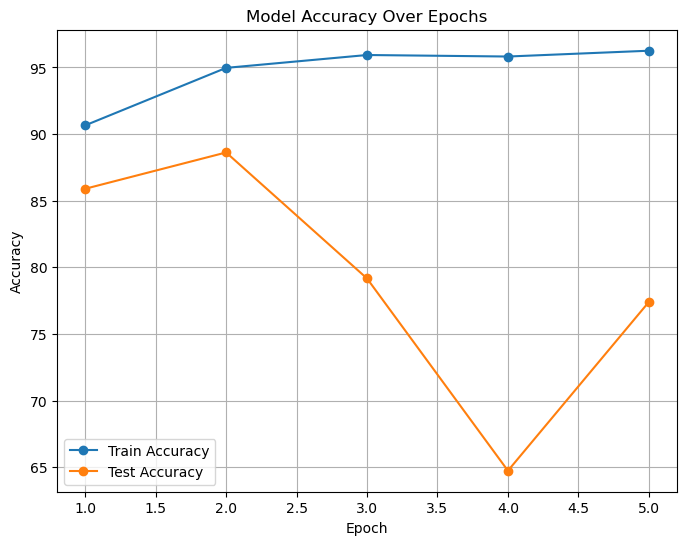

In [33]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=[8,6])
plt.plot(epochs, train_accuracies, 'o-', label='Train Accuracy')
plt.plot(epochs, test_accuracies, 'o-', label='Test Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()